In [1]:
import numpy as np
import numpy.ma as ma
import glob
import pandas as pd
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors

from sklearn import preprocessing
import scipy.interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import binned_statistic

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

import lime
import lime.lime_tabular

In [3]:
def color_list(num_bins, cmap='seismic'):
    cmap = cm.get_cmap(cmap, num_bins-1)
    colors = []
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        colors.append(mplcolors.rgb2hex(rgba))

    return colors

# Preparing the data

Prior to this notebook, I ran two scripts:

* demo_files.py
* gridding-grib2.py

The first reads the NUCAPS data in, does the surface correction, calculates CAPE, extracts some (possibly) useful metrics and metadata, and saves it to an npz file. The second script reopens the first, and using the Herbie package, appends HRRR surface CAPE values to it. I am so very glad more data like the HRRR is being moved to AWS...

Things are stored in daily files, so I have to put them together. Concatenating was the easiest method scripting wise, but the slowest. So I only kept items where there was CAPE observed in the ground truth (aka the HRRR). I set a minimum of 100 to ignore the small stuff. I am also ignoring failed retrievals, while some of these aren't terrible, have too much uncertainty for me to recommend them for regular use.

Since my science question is "What causes NUCAPS to deviate from the HRRR?" I took the difference between NUCAPS and the HRRR (predicted - actual) to show the error.

In [4]:
files = glob.glob('hrrr_matches/hwt_2022/*.csv')

In [135]:
df = pd.DataFrame()

for file in files:
    df_temp = pd.read_csv(file)

    # Only keep qc'd values, cases where there is actually CAPE
    qf_mask = (df_temp.qf == 0)
    # cape_mask = (df_temp.hrrr_cape >= 500) & (df_temp.nucaps_cape >= 500)
    df_temp = df_temp[qf_mask]

    df = pd.concat([df, df_temp], ignore_index=True)

In [136]:
df['diff'] = df['nucaps_cape']-df['hrrr_cape']

In [137]:
# df.info()

In [138]:
bin_size = 10
df["nucaps_cape_100"] = (df["nucaps_cape"]/bin_size).astype(int)*bin_size
df["hrrr_cape_100"] = (df["hrrr_cape"]/bin_size).astype(int)*bin_size

# Quick look at data
My first inspection of the data didn't look very promising - NUCAPS CAPE deviates quite a bit from the HRRR. The number of large values was especially concerning, because past work showed underestimates of CAPE, not overestimates. However, I don't know what version of NUCAPS these studies and assessments used. I went back and double checked my surface adjustment (looked okay). I also checked with the NPROVS team to see if they also showed high CAPE, but no I didn't see it. The problem was the HRRR file: I noticed none of the CAPE values exceeded 200 J/km2 there are five CAPE values in the HRRR file. I previously accidentally selected a layer CAPE, now a surface CAPE.

The second glance through looked better, but most of the values glommed around the 0,0 axis. I dropped all CAPE values below 250 (which seems reasonable for summer), and the heat maps looked much better. I also chopped the data into <1000 J/kg2 and > 1000 J/kg2 and will treat them separately.

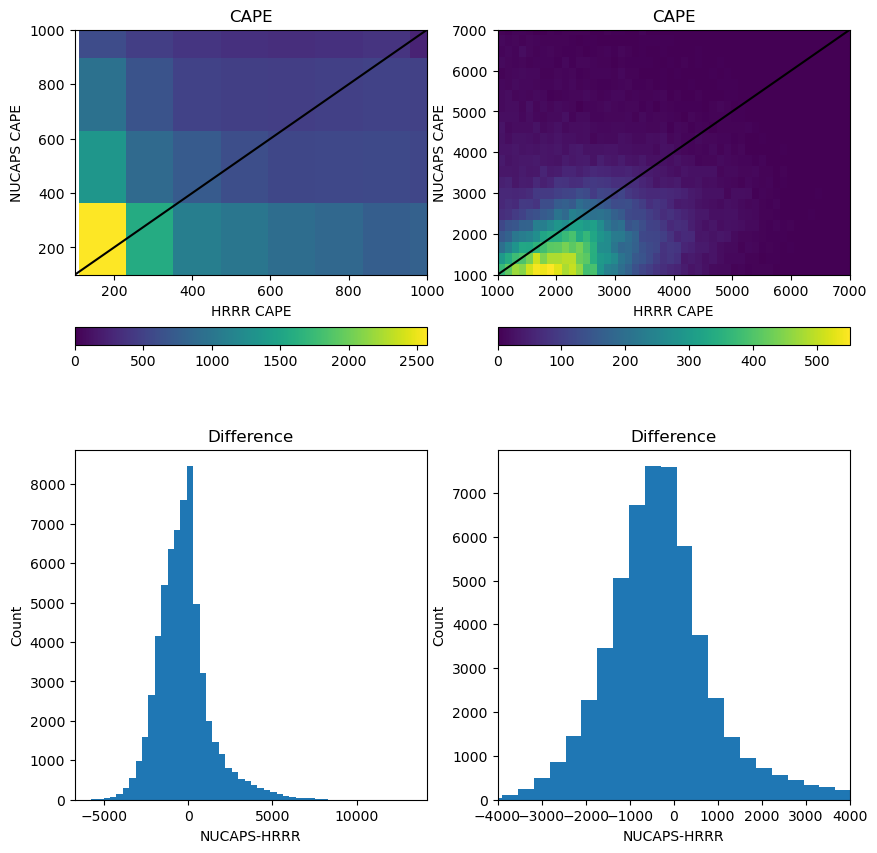

In [148]:
data = df

# normalized_nucaps = preprocessing.normalize([data.nucaps_cape.values])
# normalized_hrrr = preprocessing.normalize([data.hrrr_cape.values])
# mask2 = (normalized_nucaps > 0) & (normalized_hrrr > 0) 

lims0 = 1000
lims1 = 7000
bins = 50

mask1 = (data.nucaps_cape > 1000) & (data.hrrr_cape > 1000)
mask2 = (data.nucaps_cape > 100) & (data.hrrr_cape > 100)

# mask3 = (data.chi2temp < 0.5) & (data.chi2watr < 0.3)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[10,10])

axes[0,0].set_title('CAPE')
# axes[0].scatter(data.hrrr_cape.values[~mask1], data.nucaps_cape.values[~mask1], s=.5)
im = axes[0,0].hist2d(data.hrrr_cape_100.values[~mask1 & mask2], data.nucaps_cape_100.values[~mask1 & mask2], bins=bins, density=False)
fig.colorbar(im[3], ax=axes[0,0], orientation='horizontal')

axes[0,0].plot([0,lims], [0,lims], color='k')
axes[0,0].set_xlim(100, lims0)
axes[0,0].set_ylim(100, lims0)
axes[0,0].set_xlabel("HRRR CAPE")
axes[0,0].set_ylabel("NUCAPS CAPE")

axes[0,1].set_title('CAPE')
# axes[0].scatter(data.hrrr_cape.values[mask1], data.nucaps_cape.values[mask1], s=.5)
im = axes[0,1].hist2d(data.hrrr_cape_100.values[mask1 & mask2], data.nucaps_cape_100.values[mask1 & mask2], bins=bins, density=False)
fig.colorbar(im[3], ax=axes[0,1], orientation='horizontal')

axes[0,1].plot([0,lims], [0,lims], color='k')
axes[0,1].set_xlim(1000, lims1)
axes[0,1].set_ylim(1000, lims1)
axes[0,1].set_xlabel("HRRR CAPE")
axes[0,1].set_ylabel("NUCAPS CAPE")

axes[1,0].set_title('Difference')
axes[1,0].hist(data['diff'][~mask1 & mask2], bins=bins)
axes[1,1].set_xlim(-lims/4, lims/4)
axes[1,0].set_xlabel("NUCAPS-HRRR")
axes[1,0].set_ylabel("Count")

axes[1,1].set_title('Difference')
axes[1,1].hist(data['diff'][mask1 & mask2], bins=bins)
axes[1,1].set_xlim(-lims/2, lims/2)
axes[1,1].set_xlabel("NUCAPS-HRRR")
axes[1,1].set_ylabel("Count")

plt.show()

## Examining surface parameters

My assumption was the CAPE was highly sensitive to the surface parameters. To explore how wild NUCAPS can vary from the observed values, I am matching up to the closest station that is within 150 km of the retrieval center over the study period (5/1/2022-6/30/2022). Takes ~ 5 mins to run, so save as csv file, comment out, and reopen stored file.

In [26]:
# sfc_dir = '/home/rebekah/stability/sfc_vals/hwt_2022/'
# sfc_files = glob.glob(sfc_dir+'*.npz')

# # get columns
# df_sfc = pd.DataFrame()
# for sfc_file in sfc_files:
#     tmp = np.load(sfc_file)
        
#     file_df = pd.DataFrame()
#     for var in tmp.files:
#         try:
#             file_df[var] = pd.Series(tmp[var])
#         except:
#             file_df[var] = pd.Series(tmp[var][0])

#     df_sfc = pd.concat([df_sfc, file_df])
#     # Bad coding, fix later.
    
# df_sfc.qf[df.qf > 1] = 2
# df_sfc.to_csv('surface_vals.csv')

/tmp/ipykernel_28682/2639553898.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfc.qf[df.qf > 1] = 2


In [56]:
df_sfc = pd.read_csv('surface_vals.csv')
df_sfc['diff_temp'] = df_sfc['nc_temps']-df_sfc['obs_temp']
df_sfc['diff_dwpt'] = df_sfc['nc_dwpt']-df_sfc['obs_dwpt']

df_sfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858240 entries, 0 to 858239
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      858240 non-null  int64  
 1   lat             858240 non-null  float64
 2   lon             858240 non-null  float64
 3   times           858240 non-null  object 
 4   qf              858240 non-null  float64
 5   view_angle      858240 non-null  float64
 6   ascend          858240 non-null  float64
 7   obs_temp        471827 non-null  float64
 8   obs_dwpt        471824 non-null  float64
 9   obs_psurf       471827 non-null  float64
 10  obs_prcp        469057 non-null  float64
 11  nc_temps        471827 non-null  float64
 12  nc_dwpt         471827 non-null  float64
 13  nc_psurf        471827 non-null  float64
 14  cloud_frac      858240 non-null  float64
 15  ampl_eta_final  858240 non-null  float64
 16  Aeff_final      858240 non-null  float64
 17  A0_cloud  

The plots below show that temperature is pretty well behaved, but water vapor (in the form of Td) is not. Did some filtering based on DOF, found chi2 to be a somewhat better measure of the variability. Lower chi2 meant a closer match on the 1:1 line. Still, some of the differences are concerning, although the radius was set to be 150km and within an hour of the overpass time.

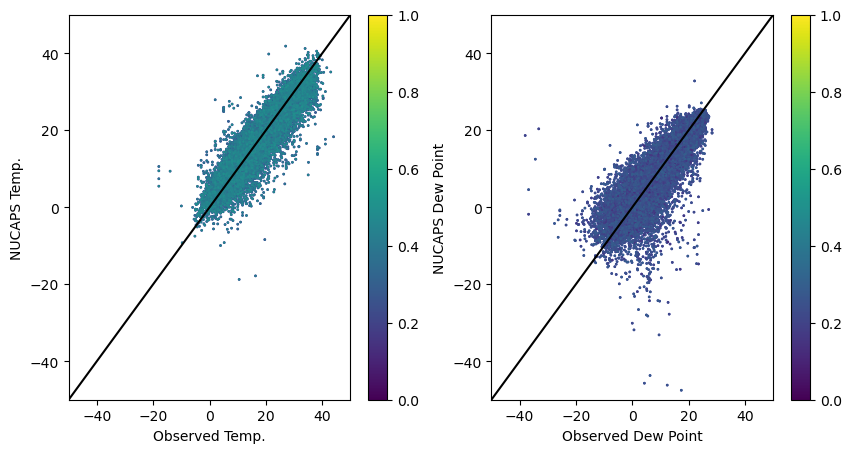

In [31]:
mask3 = (df_sfc.qf == 0) & (df_sfc.chi2temp < 0.5) & (df_sfc.chi2watr < 0.3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,5])
axes[0].scatter(df_sfc.obs_temp[mask3], df_sfc.nc_temps[mask3], s=1, c=df_sfc.qf[mask3], cmap=('RdYlBu_r'), vmin=0, vmax=2)
axes[1].scatter(df_sfc.obs_dwpt[mask3], df_sfc.nc_dwpt[mask3], s=1, c=df_sfc.qf[mask3], cmap=('RdYlBu_r'), vmin=0, vmax=2)

cb1 = axes[0].scatter(df_sfc.obs_temp[mask3], df_sfc.nc_temps[mask3], s=0.5, c=df_sfc.chi2temp[mask3], cmap=('viridis'), vmin=0, vmax=1)
cb2 = axes[1].scatter(df_sfc.obs_dwpt[mask3], df_sfc.nc_dwpt[mask3], s=0.5, c=df_sfc.chi2watr[mask3], cmap=('viridis'), vmin=0, vmax=1)

plt.colorbar(cb1)
plt.colorbar(cb2)

axes[0].set_xlabel('Observed Temp.')
axes[1].set_xlabel('Observed Dew Point')

axes[0].set_ylabel('NUCAPS Temp.')
axes[1].set_ylabel('NUCAPS Dew Point')

axes[0].set_xlim(-50,50)
axes[0].set_ylim(-50,50)
axes[0].plot([-100,100], [-100,100], color='k')

axes[1].set_xlim(-50,50)
axes[1].set_ylim(-50,50)
axes[1].plot([-100,100], [-100,100], color='k')

plt.show()

# Defining the independent and dependant variables

I saved a number of diagnostic parameters along with the CAPE values. Some of them are more difficult to explain/understand than others, but on my first pass I included all of them. My hypothesis is that one or more of the diagnostic parameters can predict the residual in some way. Translating the diagnostic paramters to "real life" is also difficult, but depending on which diagnostic parameters (again, if any) are predictors of the error, I might be able determine the kinds of scenarios. Worst case, perhaps we can adjust the QC flag or make a new one.

Note that the diagnostics have been normalized, this is SOP for ML and analytics. The scales were fairly different on most of the values.

In [173]:
data = df[mask1 & mask2].dropna()
y_var = 'diff'

# feature_names = ['view_angle','cloud_frac','ampl_eta_final','Aeff_final','A0_cloud','chi2_cloud', 'chi2temp', 'chi2watr', 'dof_temp', 'dof_watr']
feature_names = ['view_angle','ampl_eta_final','Aeff_final','chi2_cloud', 'chi2temp', 'chi2watr']
X = data[feature_names]

x = StandardScaler().fit_transform(X)
y = pd.DataFrame(data[y_var], columns=[y_var])

# Looking at the correlation matrix
[Principal component analysis (pca) with python examples tutorial](https://pub.towardsai.net/principal-component-analysis-pca-with-python-examples-tutorial-67a917bae9aa_)

There are a lot of parameters and I suspect many are hightly correlated. I iterated through the full list of parameters; the first time I found that DOFs had a large negative correlation with the other metrics whereas chi2 didn't. I dropped those. I also found that A0_cloud and chi2_cloud were correlated, but chi2 was less correlated with other vars, so I dropped A0_cloud; and so on. 

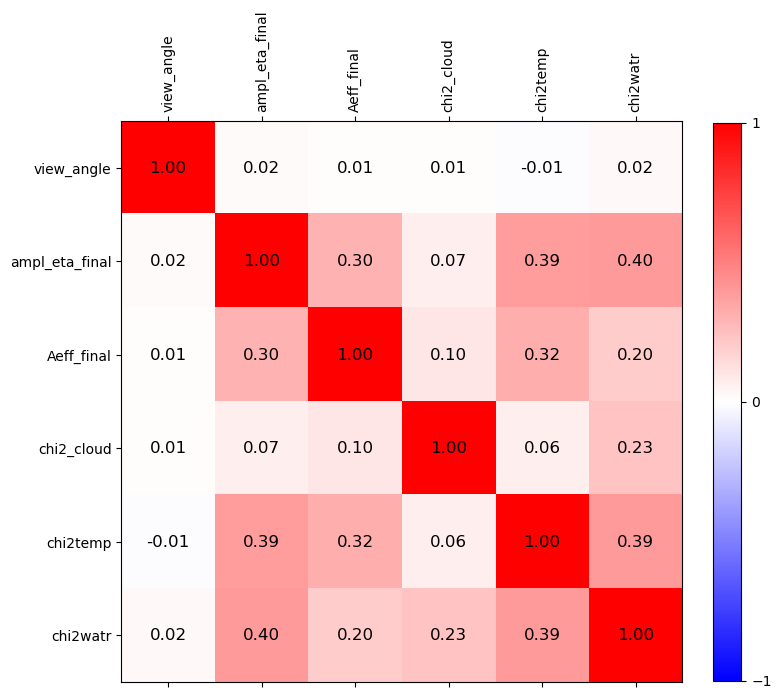

In [174]:
cov_data = np.corrcoef(np.array(x).T)

plt.figure(figsize=(8,8))
img = plt.matshow(cov_data, cmap=plt.cm.bwr, fignum=1, vmin=-1, vmax=1)
plt.colorbar(img, ticks = [-1.0, 0, 1.0], fraction=0.045)
for x1 in range(cov_data.shape[0]):
    for y1 in range(cov_data.shape[1]):
        plt.text(x1, y1, "%0.2f" % cov_data[x1,y1], size=12, color='black', ha="center", va="center")

ax = plt.gca()
plt.xticks(np.arange(0, cov_data.shape[0]))
plt.yticks(np.arange(0, cov_data.shape[0]))

ax.set_yticklabels(list(X.columns))
ax.set_xticklabels(list(X.columns))

plt.xticks(rotation=90)
plt.show()

# PCA
References:
* [PCA using Python](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
* [Be careful with your principal components](https://onlinelibrary.wiley.com/doi/10.1111/evo.13835)

I'm employing principle component analysis to see we can, in fact, explain the error using the selected diagnostics. Below, I define the number dimensions I want to reduce the dataset too. I am starting with 10, redued to 6, and using PCA, widdle down to 3. Note that the components themselves really don't have meaning, but rather just says how much we can ideally be able to explain variabce in the data.

In [175]:
num_comp = 4
pca = PCA(n_components=num_comp)
principalComponents = pca.fit_transform(x)
pca_cols = ['PC'+str(i+1).zfill(2) for i in np.arange(0, num_comp)]
principalDf = pd.DataFrame(data = principalComponents, columns = pca_cols)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

[0.34247821 0.16883388 0.16507465 0.13362114] 0.810007878729686


After running the code above, the cell prints the explained variance for each component. The sum represents the total variance explained when you add/remove components. My PC1 store decreased and my PC2 and PC3 stores increased after I reduced the number of diagnostic parameters (and total explained variance increased as a result).

* 10 vars: [0.42294317 0.13782273 0.10222424] *0.6629901394955646*
* 6 vars: [0.39173407 0.17516227 0.16645773] *0.7333540692233479*

The PCA still doesn't look at the dependent variable (error in NUCAPS CAPE). We can quickly look at the relationship between the errors and the principle components by grouping into bins. The most obvious thing I tried was the error itself, but there was not any correlation. However, I found something interested by grouping by cloud fraction in the original dataframe (remember, the number of columsn change, not rows, so we can filter by the original df is the order remains the same):

In [176]:
num_bins = 5
bin_var = y[y_var]
min_value = bin_var.min()
max_value = bin_var.max()
bins = np.linspace(min_value, max_value, num_bins)

bin_mean = np.mean(bin_var)
bin_std = np.std(bin_var)
bins = [bin_var.min(), bin_mean-bin_std, bin_mean, bin_mean+bin_std, bin_var.max()]

labels = ['bin_'+str(i) for i in np.arange(0, num_bins-1)]
colors = color_list(num_bins, cmap='viridis')
y['bins'] = pd.cut(bin_var, bins=bins, labels=labels, include_lowest=True)
finalDf = pd.concat([principalDf, y ], axis = 1)

In [198]:
data.corr()

/tmp/ipykernel_24680/2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,nucaps_lat,nucaps_lon,nucaps_cape,qf,view_angle,cloud_frac,ampl_eta_final,Aeff_final,A0_cloud,chi2_cloud,chi2temp,chi2watr,dof_temp,dof_watr,hrrr_lat,hrrr_lon,hrrr_cape,diff,nucaps_cape_100,hrrr_cape_100
nucaps_lat,1.000000,-0.269622,0.121256,NaN,-0.014119,0.016490,0.011923,0.275565,-0.034996,-0.019010,0.205234,0.036115,-0.260261,-0.072220,0.999960,-0.269661,0.063064,0.058713,0.121258,0.063064
nucaps_lon,-0.269622,1.000000,-0.395508,NaN,-0.027027,0.104004,0.158827,-0.333161,0.123857,0.075981,-0.176991,0.033793,0.028973,0.013752,-0.269996,0.999995,-0.066445,-0.285398,-0.395507,-0.066445
nucaps_cape,0.121256,-0.395508,1.000000,NaN,-0.008958,-0.100894,-0.047565,0.297250,-0.098883,-0.074563,0.240502,-0.050076,-0.095994,0.168603,0.121241,-0.395583,0.134656,0.744079,0.999997,0.134656
qf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view_angle,-0.014119,-0.027027,-0.008958,NaN,1.000000,0.020453,0.018208,0.012993,0.013264,0.010606,-0.013099,0.023914,-0.031004,-0.010931,-0.014205,-0.027016,-0.007134,-0.002668,-0.008962,-0.007134
cloud_frac,0.016490,0.104004,-0.100894,NaN,0.020453,1.000000,0.565454,0.308397,0.507945,0.400917,0.292755,0.454532,-0.525268,-0.259772,0.016510,0.103984,-0.050150,-0.050421,-0.100900,-0.050150
ampl_eta_final,0.011923,0.158827,-0.047565,NaN,0.018208,0.565454,1.000000,0.298997,0.304542,0.066365,0.387525,0.396354,-0.696357,-0.312594,0.011933,0.158842,-0.011992,-0.031625,-0.047576,-0.011992
Aeff_final,0.275565,-0.333161,0.297250,NaN,0.012993,0.308397,0.298997,1.000000,0.153194,0.097482,0.316643,0.198035,-0.595556,-0.394346,0.275673,-0.333246,-0.102211,0.317079,0.297253,-0.102211
A0_cloud,-0.034996,0.123857,-0.098883,NaN,0.013264,0.507945,0.304542,0.153194,1.000000,0.653227,0.140713,0.254275,-0.282614,-0.153518,-0.035029,0.123853,-0.048656,-0.049748,-0.098886,-0.048656
chi2_cloud,-0.019010,0.075981,-0.074563,NaN,0.010606,0.400917,0.066365,0.097482,0.653227,1.000000,0.064501,0.230086,-0.163785,-0.078158,-0.019037,0.075990,-0.043993,-0.032588,-0.074558,-0.043993


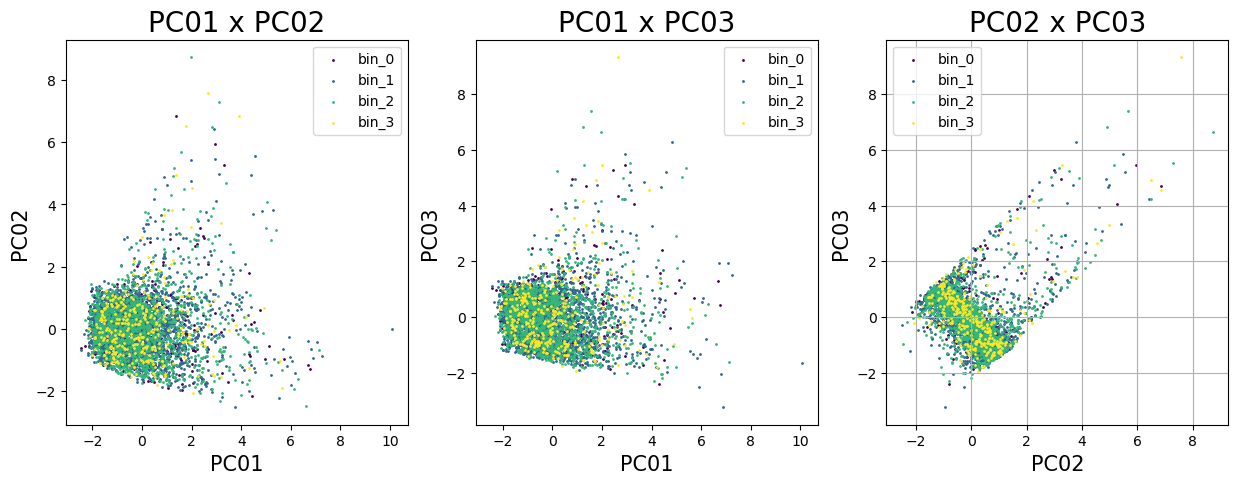

In [179]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1,3,1) 
ax.set_xlabel('PC01', fontsize = 15)
ax.set_ylabel('PC02', fontsize = 15)
ax.set_title('PC01 x PC02', fontsize = 20)

for target, color in zip(labels, colors):
    indicesToKeep = finalDf['bins'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC01']
               , finalDf.loc[indicesToKeep, 'PC02']
               , c = color
               , s = 1)
ax.legend(labels)

ax = fig.add_subplot(1,3,2) 
ax.set_xlabel('PC01', fontsize = 15)
ax.set_ylabel('PC03', fontsize = 15)
ax.set_title('PC01 x PC03', fontsize = 20)

for target, color in zip(labels, colors):
    indicesToKeep = finalDf['bins'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC01']
               , finalDf.loc[indicesToKeep, 'PC03']
               , c = color
               , s = 1)
ax.legend(labels)

ax = fig.add_subplot(1,3,3) 
ax.set_xlabel('PC02', fontsize = 15)
ax.set_ylabel('PC03', fontsize = 15)
ax.set_title('PC02 x PC03', fontsize = 20)

for target, color in zip(labels, colors):
    indicesToKeep = finalDf['bins'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC02']
               , finalDf.loc[indicesToKeep, 'PC03']
               , c = color
               , s = 1)
ax.legend(labels)


ax.grid()

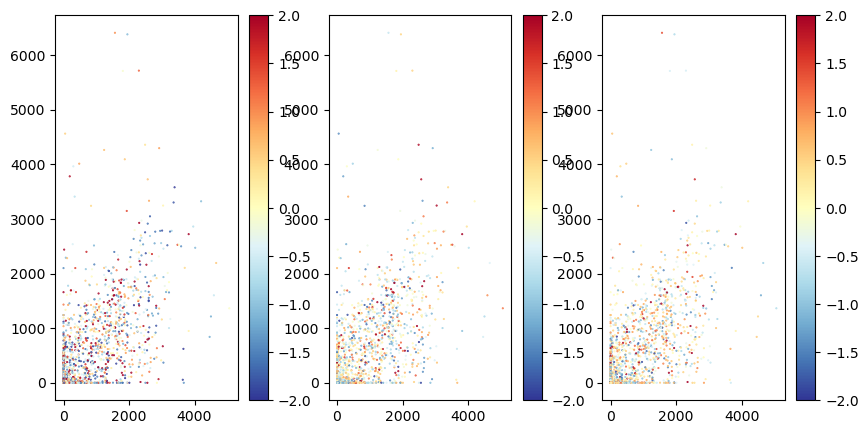

In [180]:
combined_df = pd.concat([principalDf, df.dropna() ], axis = 1)
combined_df = combined_df[(combined_df.qf == 0)&  (combined_df.chi2temp < 0.5) & (combined_df.chi2watr < 0.3)]


plt.figure(figsize=[10,5])

ax = plt.subplot(131)
tmp = ax.scatter(combined_df.hrrr_cape, combined_df.nucaps_cape, c=combined_df.PC01, vmin=-2, vmax=2, s=0.25, cmap='RdYlBu_r')
# ax.scatter(combined_df.obs_temp, combined_df.nc_temps, c=combined_df.PC01, vmin=-1, vmax=1, s=0.1, cmap='RdYlBu_r')
plt.colorbar(tmp)

ax= plt.subplot(132)
tmp = ax.scatter(combined_df.hrrr_cape, combined_df.nucaps_cape, c=combined_df.PC02, vmin=-2, vmax=2, s=0.25, cmap='RdYlBu_r')
# ax.scatter(combined_df.obs_temp, combined_df.nc_temps, c=combined_df.PC02, vmin=-1, vmax=1, s=0.1, cmap='RdYlBu_r')
plt.colorbar(tmp)

ax= plt.subplot(133)
tmp = plt.scatter(combined_df.hrrr_cape, combined_df.nucaps_cape, c=combined_df.PC03, vmin=-2, vmax=2, s=0.25, cmap='RdYlBu_r')

# tmp = ax.scatter(combined_df.obs_temp, combined_df.nc_temps, c=combined_df.PC03, vmin=-1, vmax=1, s=0.1, cmap='RdYlBu_r')

plt.colorbar(tmp)
plt.show()

# Random Forest Regressor
Resources:
* [Introduction to Explainable AI(XAI) using LIME](https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/)
* [Evaluating a Random Forest model](https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56)
* [A Quick and Dirty Guide to Random Forest Regression](https://towardsdatascience.com/a-quick-and-dirty-guide-to-random-forest-regression-52ca0af157f8)

Regardless of technique, we need to split the data into testing and training groups. Scikitlearn has some helpful functions to do that.

In [182]:
X_train, X_test, y_train, y_test = train_test_split(x, y['diff'], test_size = 0.3, random_state = 1)

It's stupid easy to code up a machine learning model, which is both convenient and terrifying:

In [183]:
model = RandomForestRegressor(max_depth=3, random_state=1, n_estimators=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=10, random_state=1)

Below I predict the y values based on the test dataset. After that, we compute the MSE and the RMSE for the model.

In [184]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)**(0.5)
print(mse, mse**.5)

1276.3117762364081 35.725505961937166


# Explainable AI

One of my learning goals was to understand explainable AI a bit more. The Local  Interpretable Model-agnostic Explanations (LIME) technique can be paired with a machine learning model by passing a single case in and seeing the impact of various prectitors on the dependent variable. It's kind of neat and it could be interesting for this study if it makes sense to employ ML here (over traditional, and thereby interpretable, statistics).

First you start by defining the explainer, which can be either a regression or a classification.

In [185]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['difference_cape'], verbose=True, mode='regression')

Then you pass in a single data point. I like this approach because it reminds me of a "case study," and I can deep dive a specific event.

In [197]:
# j = 100
j = 1000
exp = explainer.explain_instance(X_test[j], model.predict, num_features=20)
exp.show_in_notebook(show_table=True)

Intercept -114.69899755345928
Prediction_local [-362.67635954]
Right: -576.5283458827801
